# 🧪 Preprocessing Validation Notebook — 3번 역할 전용

### 3번 역할의 핵심 업무
1. `baseline_stats` 수집 → 2번 파이프라인 결과가 **설계와 일치하는지 비교**할 기준값 만들기  
2. 설계서에 정의된 **Feature Engineering(FE) 후보 4개** 검증  
   - `engagement_score`  
   - `listening_time_bin`  
   - `skip_rate_cap`  
   - `ads_pressure`  
3. (선택) 타깃 분포 확인 → 데이터 불균형 정도만 파악  
4. 2번이 만든 `preprocess_pipeline()` 이 **정상 동작하는지 QA 코드로 검증**


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# 1) matplotlib 한글 폰트 설정
mpl.rcParams['font.family'] = ['Malgun Gothic']
mpl.rcParams['axes.unicode_minus'] = False

# 2) seaborn도 같은 폰트 쓰도록 설정
sns.set(style="whitegrid", font="Malgun Gothic", rc={"axes.unicode_minus": False})

## 1. 원본 데이터 로드

**전체 EDA를 다시 하지 않고**,  
`baseline_stats`와 FE 검증에 필요한 최소한의 정보만 확인합니다.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

#  필요에 따라 경로 수정
DATA_PATH = '../data/raw_data.csv'

df = pd.read_csv(DATA_PATH)
df.head()

,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26.0,23.0,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141.0,62.0,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199.0,38.0,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36.0,2.0,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250.0,57.0,0.36,Mobile,0,1,1


## 2. Baseline Stats (전처리 검증용 기준값)

2번 파이프라인이 올바르게 처리되었는지 확인하기 위해,  
원본 데이터 기준으로 **핵심 통계값들을 한 번만 계산**해 둡니다.

- `median` / `max` / `q99` (상위 1% 기준)  
  - `listening_time`  
  - `songs_played_per_day`  
  - `skip_rate`  
- `country_top5` (이용자 수 상위 5개 국가)
- `subscription_type_unique`
- `device_type_unique`


In [3]:
baseline_stats = {}

# 2-1. 수치형 기준값
num_cols = ['listening_time', 'songs_played_per_day', 'skip_rate']
for col in num_cols:
    if col in df.columns:
        baseline_stats[f'{col}_median'] = df[col].median()
        baseline_stats[f'{col}_max'] = df[col].max()
        baseline_stats[f'{col}_q99'] = df[col].quantile(0.99)

# 2-2. 범주형 기준값
if 'country' in df.columns:
    baseline_stats['country_top5'] = df['country'].value_counts().head(5).index.tolist()

if 'subscription_type' in df.columns:
    baseline_stats['subscription_type_unique'] = df['subscription_type'].unique().tolist()

if 'device_type' in df.columns:
    baseline_stats['device_type_unique'] = df['device_type'].unique().tolist()

baseline_stats

{'listening_time_median': np.float64(154.0),
 'listening_time_max': np.float64(299.0),
 'listening_time_q99': np.float64(297.0),
 'songs_played_per_day_median': np.float64(50.0),
 'songs_played_per_day_max': np.float64(99.0),
 'songs_played_per_day_q99': np.float64(98.0),
 'skip_rate_median': np.float64(0.305),
 'skip_rate_max': np.float64(4.980194893630863),
 'skip_rate_q99': np.float64(3.1209042144663313),
 'country_top5': ['AU', 'US', 'DE', 'IN', 'PK'],
 'subscription_type_unique': ['Free', 'Family', 'Premium', 'Student'],
 'device_type_unique': ['Desktop', 'Web', 'Mobile']}

### 2-3. (선택) baseline_stats를 JSON 파일로 저장

나중에 2번 파이프라인 결과와 비교할 때,  
같은 기준을 재사용하기 쉽도록 파일로 저장해 둡니다.


In [4]:
import json

with open('../data/baseline_stats.json', 'w', encoding='utf-8') as f:
    json.dump(baseline_stats, f, ensure_ascii=False, indent=2)

print('✅ baseline_stats.json 저장 완료')

✅ baseline_stats.json 저장 완료


## 3. Target 분포 확인 (선택)
**필수 업무는 아니지만**,  
데이터 불균형 정도를 알고 있으면 **모델 성능 해석**에 도움이 됩니다.


In [5]:
if 'is_churned' in df.columns:
    print('is_churned 분포 (비율):')
    print(df['is_churned'].value_counts(normalize=True).rename('ratio'))
else:
    print("⚠️ 'is_churned' 컬럼이 없습니다.")

is_churned 분포 (비율):
is_churned
0    0.741125
1    0.258875
Name: ratio, dtype: float64


## 4. Feature Engineering 후보 4개 실험

1번(설계자)이 정의한 FE 후보들 중에서,  
아래 4개를 실제로 만들어 보고 값이 정상적으로 계산되는지만 간단히 확인합니다.

- `engagement_score` : 듣는 시간 × 곡 수(활동 강도)
- `listening_time_bin` : 사용 시간을 low / mid / high로 구간화한 변수
- `skip_rate_cap` : 이상치를 줄이기 위해 cap(0~1.5)을 적용한 스킵률
- `ads_pressure` : 듣는 시간 대비 광고 노출 강도 (`ads_listened_per_week / listening_time`)

In [6]:
df_fe = df.copy()

# 4-1. engagement_score (활동 강도)
if {'listening_time', 'songs_played_per_day'}.issubset(df_fe.columns):
    # 설계서 정의: listening_time × songs_played_per_day
    df_fe['engagement_score'] = df_fe['listening_time'] * df_fe['songs_played_per_day']
else:
    print('⚠️ engagement_score를 만들기 위한 컬럼이 부족합니다.')

# 4-2. listening_time_bin (low / mid / high)
if 'listening_time' in df_fe.columns:
    try:
        # 전체 분포를 3등분해서 low/mid/high 구간으로 나눔
        df_fe['listening_time_bin'] = pd.qcut(df_fe['listening_time'], 3, labels=['low', 'mid', 'high'])
    except Exception as e:
        # qcut이 실패하면 단순 구간 기준으로 나누기
        bins = [0, 60, 180, df_fe['listening_time'].max()]
        labels = ['low', 'mid', 'high']
        df_fe['listening_time_bin'] = pd.cut(df_fe['listening_time'], bins=bins, labels=labels, include_lowest=True)
else:
    print('⚠️ listening_time 컬럼이 없습니다.')

# 4-3. skip_rate_cap (0 ~ 1.5 cap)
if 'skip_rate' in df_fe.columns:
    df_fe['skip_rate_cap'] = df_fe['skip_rate'].clip(lower=0, upper=1.5)
else:
    print('⚠️ skip_rate 컬럼이 없습니다.')

# 4-4. ads_pressure = ads_listened_per_week / listening_time
if {'ads_listened_per_week', 'listening_time'}.issubset(df_fe.columns):
    # 설계서 정의를 따르되, listening_time이 0인 경우는 NaN 처리
    lt_nonzero = df_fe['listening_time'].replace(0, np.nan)
    df_fe['ads_pressure'] = df_fe['ads_listened_per_week'] / lt_nonzero
else:
    print('⚠️ ads_pressure를 만들기 위한 컬럼이 부족합니다.')

df_fe[['engagement_score', 'listening_time_bin', 'skip_rate_cap', 'ads_pressure']].head()

,engagement_score,listening_time_bin,skip_rate_cap,ads_pressure
0,598.0,low,0.20,1.192308
1,8742.0,mid,0.34,0.000000
2,7562.0,mid,0.04,0.000000
3,72.0,low,0.31,0.000000
4,14250.0,high,0.36,0.000000


## 5. FE 변수와 이탈률의 **관계** 확인

각 파생변수별로 이탈률 평균만 비교해서 **대략적으로 유의미한지 감만 보는 수준**만 수행합니다.

- `engagement_score`
- `listening_time_bin`
- `skip_rate_cap`
- `ads_pressure`


In [7]:
if 'is_churned' in df_fe.columns:
    for col in ['engagement_score', 'listening_time_bin', 'skip_rate_cap', 'ads_pressure']:
        if col in df_fe.columns:
            print(f'\n=== {col} vs is_churned ===')
            
            # 범주형(또는 구간형) 변수: listening_time_bin
            if col == 'listening_time_bin' or df_fe[col].dtype in ['int64', 'int32', 'bool', 'category', 'object']:
                print(df_fe.groupby(col)['is_churned'].mean().rename('churn_rate'))
            else:
                # 연속형은 단순 4분위 구간별 평균만 확인
                try:
                    bins = pd.qcut(df_fe[col], 4, duplicates='drop')
                    print(df_fe.groupby(bins)['is_churned'].mean().rename('churn_rate'))
                except Exception as e:
                    print('  (분위수 분할 불가, 분포가 한쪽에 치우쳤을 수 있음)')
else:
    print("⚠️ 'is_churned' 컬럼이 없어 FE-타깃 관계를 계산할 수 없습니다.")


=== engagement_score vs is_churned ===
engagement_score
(9.999, 2328.0]       0.248540
(2328.0, 5891.0]      0.271520
(5891.0, 11722.5]     0.263830
(11722.5, 29601.0]    0.254516
Name: churn_rate, dtype: float64

=== listening_time_bin vs is_churned ===
listening_time_bin
low     0.260718
mid     0.265715
high    0.252133
Name: churn_rate, dtype: float64

=== skip_rate_cap vs is_churned ===
skip_rate_cap
(-0.001, 0.15]    0.256284
(0.15, 0.305]     0.245053
(0.305, 0.46]     0.260048
(0.46, 1.5]       0.274419
Name: churn_rate, dtype: float64

=== ads_pressure vs is_churned ===
ads_pressure
(-0.001, 0.0239]    0.263230
(0.0239, 3.9]       0.248454
Name: churn_rate, dtype: float64


C:\Users\USER\AppData\Local\Temp\ipykernel_7648\1144278135.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_fe.groupby(bins)['is_churned'].mean().rename('churn_rate'))
C:\Users\USER\AppData\Local\Temp\ipykernel_7648\1144278135.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_fe.groupby(col)['is_churned'].mean().rename('churn_rate'))
C:\Users\USER\AppData\Local\Temp\ipykernel_7648\1144278135.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt

### 5-1. FE 4개 vs 이탈률 시각화 설명

아래 시각화는 설계된 FE 4개(`engagement_score`, `listening_time_bin`, `skip_rate_cap`, `ads_pressure`)에 대해
각 구간별 이탈률(churn_rate)과 표본 수(count)를 함께 보여줍니다.

- 왼쪽 열(각 행의 왼쪽 그래프):
  - x축: 해당 FE의 구간(bin)
  - y축: 각 구간에 속한 사용자들의 평균 이탈률(`is_churned` 평균)
  - 의미: "이 Feature 값이 커지거나 구간이 바뀔 때 이탈률이 어떻게 변하는지"를 한눈에 확인

- 오른쪽 열(각 행의 오른쪽 그래프):
  - x축: 동일한 구간(bin)
  - y축: 각 구간에 포함된 표본 수(count)
  - 의미: "이탈률이 달라 보여도, 그 구간에 사용자가 얼마나 있는지"를 같이 보기 위함

이를 통해 각 FE가 이탈률을 얼마나 잘 나누는지, 그리고 그 패턴이 충분히 신뢰할 만한 표본 수를 기반으로 하는지
EDA 수준에서 직관적으로 판단할 수 있습니다.


C:\Users\USER\AppData\Local\Temp\ipykernel_7648\2934909998.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  eng_stats = df_fe.groupby(eng_bins)['is_churned'].agg(churn_rate='mean', count='size').reset_index()
C:\Users\USER\AppData\Local\Temp\ipykernel_7648\2934909998.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=eng_stats, x='bin', y='churn_rate', ax=axes[0, 0], palette='Blues')
C:\Users\USER\AppData\Local\Temp\ipykernel_7648\2934909998.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barp

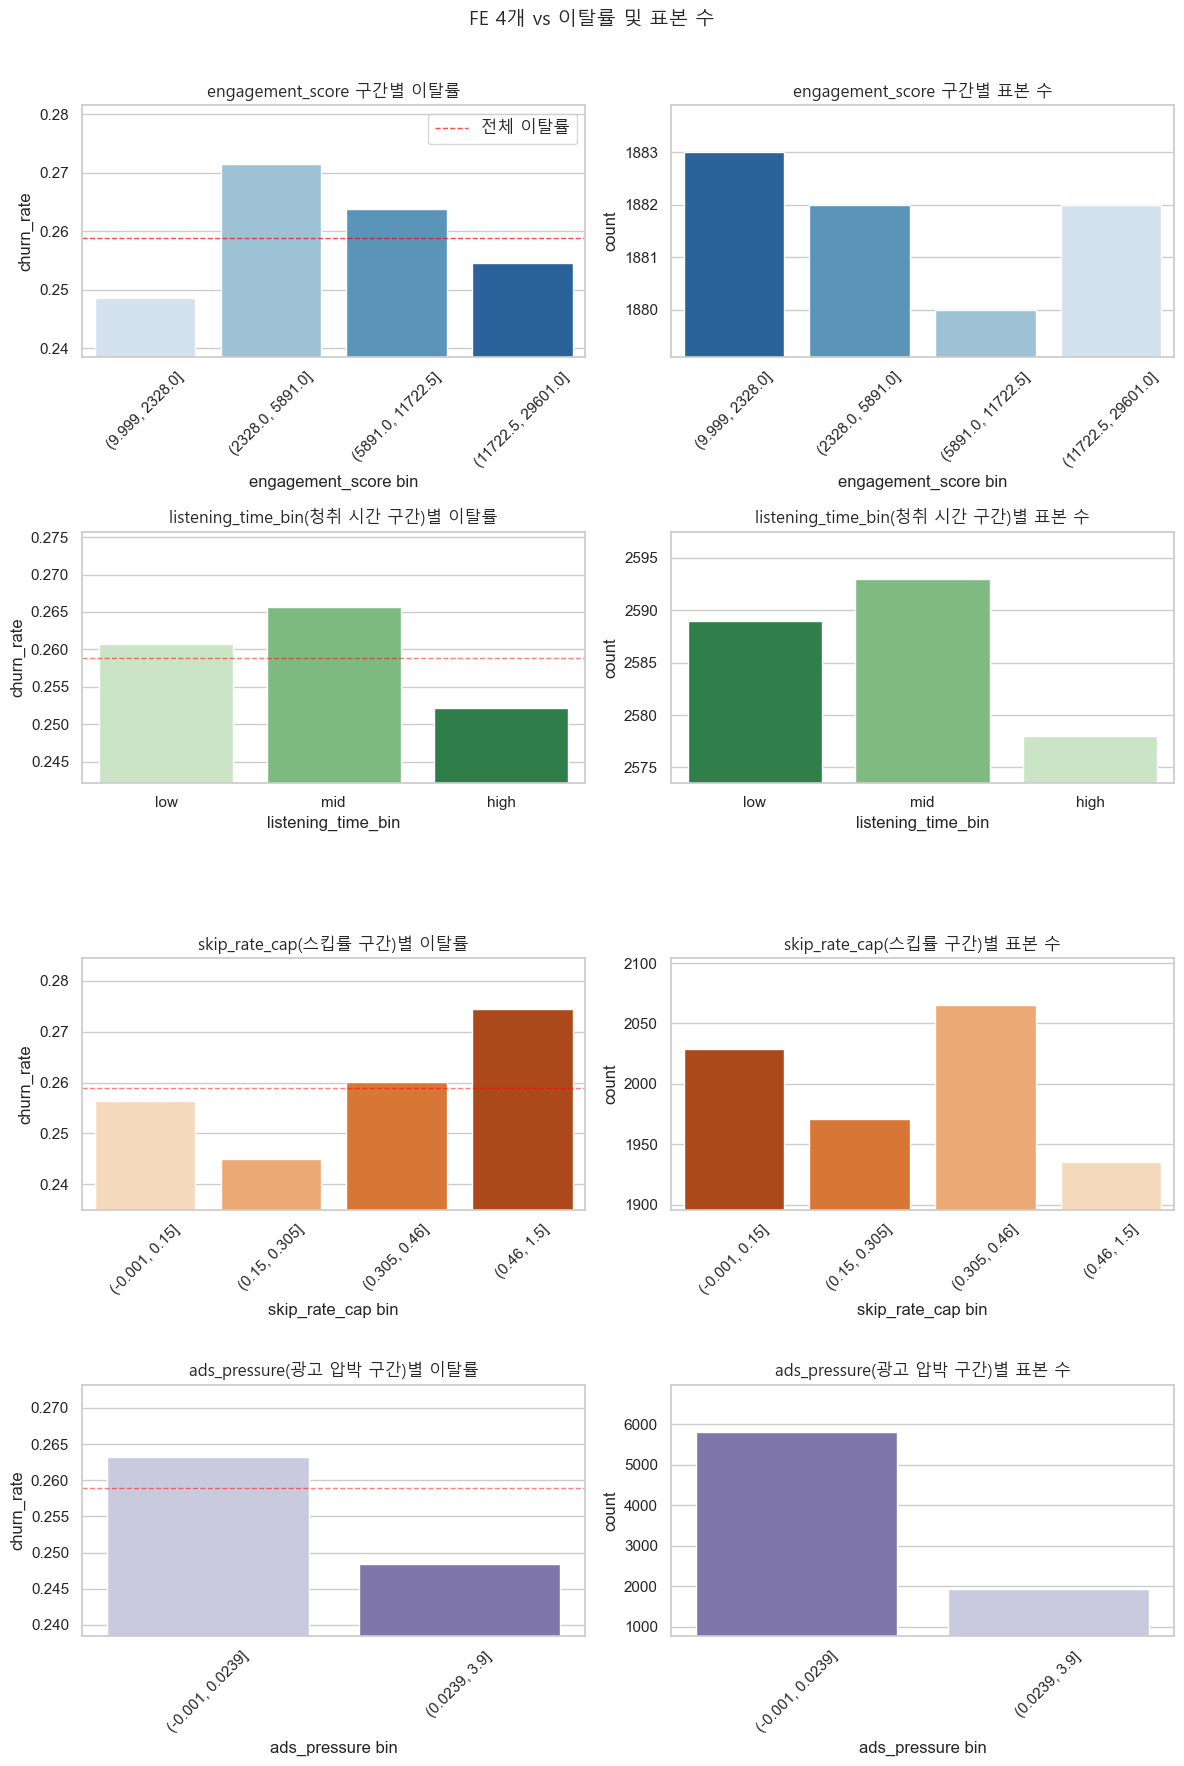

In [8]:
# 5-1. FE 4개 vs 이탈률 시각화 (bar plot)
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

sns.set(style="whitegrid")

# 한글 폰트 설정 (Windows: Malgun Gothic)
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)

fig, axes = plt.subplots(4, 2, figsize=(12, 18))
fig.suptitle('FE 4개 vs 이탈률 및 표본 수', fontsize=14, fontproperties=font_prop)

# 전체 평균 이탈률 (참고용 기준선)
global_churn = df_fe['is_churned'].mean() if 'is_churned' in df_fe.columns else None

# 1) engagement_score
eng_bins = pd.qcut(df_fe['engagement_score'], 4, duplicates='drop')
eng_stats = df_fe.groupby(eng_bins)['is_churned'].agg(churn_rate='mean', count='size').reset_index()
eng_stats['bin'] = eng_stats['engagement_score'].astype(str)

sns.barplot(data=eng_stats, x='bin', y='churn_rate', ax=axes[0, 0], palette='Blues')
axes[0, 0].set_title('engagement_score 구간별 이탈률', fontproperties=font_prop)
axes[0, 0].set_xlabel('engagement_score bin')
axes[0, 0].set_ylabel('churn_rate')
axes[0, 0].tick_params(axis='x', rotation=45)

sns.barplot(data=eng_stats, x='bin', y='count', ax=axes[0, 1], palette='Blues_r')
axes[0, 1].set_title('engagement_score 구간별 표본 수', fontproperties=font_prop)
axes[0, 1].set_xlabel('engagement_score bin')
axes[0, 1].set_ylabel('count')
axes[0, 1].tick_params(axis='x', rotation=45)

# 2) listening_time_bin
lt_stats = df_fe.groupby('listening_time_bin')['is_churned'].agg(churn_rate='mean', count='size').reset_index()

sns.barplot(data=lt_stats, x='listening_time_bin', y='churn_rate', ax=axes[1, 0], palette='Greens')
axes[1, 0].set_title('listening_time_bin(청취 시간 구간)별 이탈률', fontproperties=font_prop)
axes[1, 0].set_xlabel('listening_time_bin')
axes[1, 0].set_ylabel('churn_rate')

sns.barplot(data=lt_stats, x='listening_time_bin', y='count', ax=axes[1, 1], palette='Greens_r')
axes[1, 1].set_title('listening_time_bin(청취 시간 구간)별 표본 수', fontproperties=font_prop)
axes[1, 1].set_xlabel('listening_time_bin')
axes[1, 1].set_ylabel('count')

# 3) skip_rate_cap
skip_bins = pd.qcut(df_fe['skip_rate_cap'], 4, duplicates='drop')
skip_stats = df_fe.groupby(skip_bins)['is_churned'].agg(churn_rate='mean', count='size').reset_index()
skip_stats['bin'] = skip_stats['skip_rate_cap'].astype(str)

sns.barplot(data=skip_stats, x='bin', y='churn_rate', ax=axes[2, 0], palette='Oranges')
axes[2, 0].set_title('skip_rate_cap(스킵률 구간)별 이탈률', fontproperties=font_prop)
axes[2, 0].set_xlabel('skip_rate_cap bin')
axes[2, 0].set_ylabel('churn_rate')
axes[2, 0].tick_params(axis='x', rotation=45)

sns.barplot(data=skip_stats, x='bin', y='count', ax=axes[2, 1], palette='Oranges_r')
axes[2, 1].set_title('skip_rate_cap(스킵률 구간)별 표본 수', fontproperties=font_prop)
axes[2, 1].set_xlabel('skip_rate_cap bin')
axes[2, 1].set_ylabel('count')
axes[2, 1].tick_params(axis='x', rotation=45)

# 4) ads_pressure (결측 제거 후)
ads_series = df_fe['ads_pressure'].dropna()
if not ads_series.empty:
    ads_bins = pd.qcut(ads_series, 4, duplicates='drop')
    tmp = df_fe.loc[ads_series.index].copy()
    tmp['ads_bin'] = ads_bins
    ads_stats = tmp.groupby('ads_bin')['is_churned'].agg(churn_rate='mean', count='size').reset_index()
    ads_stats['bin'] = ads_stats['ads_bin'].astype(str)

    sns.barplot(data=ads_stats, x='bin', y='churn_rate', ax=axes[3, 0], palette='Purples')
    axes[3, 0].set_title('ads_pressure(광고 압박 구간)별 이탈률', fontproperties=font_prop)
    axes[3, 0].set_xlabel('ads_pressure bin')
    axes[3, 0].set_ylabel('churn_rate')
    axes[3, 0].tick_params(axis='x', rotation=45)

    sns.barplot(data=ads_stats, x='bin', y='count', ax=axes[3, 1], palette='Purples_r')
    axes[3, 1].set_title('ads_pressure(광고 압박 구간)별 표본 수', fontproperties=font_prop)
    axes[3, 1].set_xlabel('ads_pressure bin')
    axes[3, 1].set_ylabel('count')
    axes[3, 1].tick_params(axis='x', rotation=45)
else:
    axes[3, 0].set_visible(False)
    axes[3, 1].set_visible(False)

# 이탈률(y축) 차이를 더 잘 보기 위해, 각 이탈률 그래프의 y축 범위를
# 해당 변수의 churn_rate 최소~최대 근처로 좁혀서 표시

def zoom_rate_axis(ax, rates, margin=0.01):
    rmin = float(rates.min())
    rmax = float(rates.max())
    # margin을 포함해 살짝 여유를 둠
    ax.set_ylim(rmin - margin, rmax + margin)

# 1) engagement_score 이탈률 y축 확대
zoom_rate_axis(axes[0, 0], eng_stats['churn_rate'])

# 2) listening_time_bin 이탈률 y축 확대
zoom_rate_axis(axes[1, 0], lt_stats['churn_rate'])

# 3) skip_rate_cap 이탈률 y축 확대
zoom_rate_axis(axes[2, 0], skip_stats['churn_rate'])

# 4) ads_pressure 이탈률 y축 확대 (데이터가 있을 때만)
if not ads_series.empty:
    zoom_rate_axis(axes[3, 0], ads_stats['churn_rate'])

# 전체 평균 이탈률 기준선 추가 (왼쪽 열 이탈률 그래프들)
if global_churn is not None:
    axes[0, 0].axhline(global_churn, color='red', linestyle='--', linewidth=1, alpha=0.7, label='전체 이탈률')
    axes[1, 0].axhline(global_churn, color='red', linestyle='--', linewidth=1, alpha=0.5)
    axes[2, 0].axhline(global_churn, color='red', linestyle='--', linewidth=1, alpha=0.5)
    if not ads_series.empty:
        axes[3, 0].axhline(global_churn, color='red', linestyle='--', linewidth=1, alpha=0.5)
    # 한글 깨짐 방지를 위해 범례에도 동일 폰트 적용
    axes[0, 0].legend(loc='upper right', fontsize=9, prop=font_prop)

# 표본 수(count) 차이를 보기 쉽게 하기 위해, 각 count 그래프도
# 최소~최대 주변으로 y축을 자동 확대

def zoom_count_axis(ax, counts, margin_ratio=0.3):
    cmin = float(counts.min())
    cmax = float(counts.max())
    if cmax == cmin:
        # 모든 구간의 표본 수가 같다면 약간의 여유만 줌
        ax.set_ylim(cmin - 1, cmax + 1)
    else:
        delta = (cmax - cmin) * margin_ratio
        ax.set_ylim(cmin - delta, cmax + delta)

# 1) engagement_score 표본 수 y축 확대
zoom_count_axis(axes[0, 1], eng_stats['count'])

# 2) listening_time_bin 표본 수 y축 확대
zoom_count_axis(axes[1, 1], lt_stats['count'])

# 3) skip_rate_cap 표본 수 y축 확대
zoom_count_axis(axes[2, 1], skip_stats['count'])

# 4) ads_pressure 표본 수 y축 확대 (데이터가 있을 때만)
if not ads_series.empty:
    zoom_count_axis(axes[3, 1], ads_stats['count'])

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


## 6. FE 개선안 리스트

### 6-1. 현재 구현된 4개 FE 최종 의견

| Feature | 권장 용도/상태 | 한 줄 코멘트 |
| --- | --- | --- |
| engagement_score | **보조 Feature로 유지** | 활동 강도(듣는 시간 × 곡 수)를 잘 표현하지만 이탈률 격차는 크지 않음 → 해석/설명용 보조 변수로 유지 추천 |
| listening_time_bin | **설명용/시각화 위주로 사용** | low/mid/high 간 이탈률 차이가 작아 모델 핵심 변수보다는 리포트/시각화용으로 활용 권장 |
| skip_rate_cap | **전처리 단계에서 필수 유지** | 극단적인 스킵률을 캡핑해 분포를 안정화하는 역할 → 이후 다른 파생변수(`skip_intensity` 등)의 기반 변수로 활용 가치 큼 |
| ads_pressure | **분석·군집용 보조 변수 (모델에는 우선순위 낮음)** | 광고 노출 강도와 이탈률의 직접적인 차이는 크지 않지만, 헤비 유저/광고 민감 유저 군집을 나눌 때 보조 지표로 활용 가능 |

---

### 6-2. `pipeline_design.md` 기반 추가 FE 후보 (간단 가이드)

3번 역할 관점에서, 추가 FE는 **“어떤 걸 먼저 실험해 볼지”** 정도만 정리해 두면 충분하다고 보고, 최소 가이드만 남깁니다.

- **꼭 한 번은 실험해 볼 것**
  - `songs_per_minute = songs_played_per_day / listening_time`  
    → 시간 대비 재생곡 수로 **사용 강도**를 더 잘 드러내는 지표.
  - `skip_intensity = skip_rate * songs_played_per_day`  
    → 스킵 비율 × 재생곡 수 = **실제 스킵 행동량**을 반영, 고스킵/저스킵 유저 구분에 유용할 가능성.
  - `subscription_type_level` (예: Family=3, Premium=2, Student=1, Free=0)  
    → 요금제별 이탈률 차이를 **순서 있는 수치형 변수** 하나로 반영.

- **여유가 있을 때 검토해 볼 것**
  - `age_group` (young/adult/senior 등)  
    → 나이대를 단순화해서 쓰는 옵션. 기본 `age`와 중복 가능성이 있어, 필요할 때만.
  - `ads_listened_log` (ads_listened_per_week 로그 변환)  
    → 광고 노출 수의 극단값/왜도 완화용. 주로 선형 계열 모델에서 의미가 있을 수 있음.
  - 그 외 교호작용 Feature (예: `listening_time × subscription_type_level` 등)  
    → 기본 FE 조합으로 성능을 먼저 본 뒤, 추가 실험이 필요할 때 소수만 선택해 테스트.


## 7. 전처리 파이프라인 QA 
검증 항목:
1. `X_train`, `X_test`, `y_train`, `y_test` shape 정상 여부  
2. 결측치가 모두 제거되었는지  
3. 타깃 분포가 원본과 크게 달라지지 않았는지  
4. 설계된 FE(`engagement_score`, `listening_time_bin`, `skip_rate_cap`, `ads_pressure`)가 실제 포함되어 있는지  
5. (선택) baseline_stats와 비교하여 이상치 처리가 되었는지


In [10]:
import os, sys, json

# 1) 프로젝트 루트 경로 추가 + 파이프라인 import
ROOT_DIR = os.path.abspath("..")
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

from backend.pipeline_test import prepare_dataset

# 2) baseline_stats 로드 (있으면)
try:
    with open('../data/baseline_stats.json', 'r', encoding='utf-8') as f:
        baseline_loaded = json.load(f)
except FileNotFoundError:
    baseline_loaded = None
    print("⚠️ baseline_stats.json 파일을 찾을 수 없습니다.")

# 3) 파이프라인 실행 (raw_data.csv 경로는 필요하면 수정)
DATA_PATH = "../data/raw_data.csv"
X_train, X_test, y_train, y_test, preprocessor = prepare_dataset(DATA_PATH)

print("X_train shape:", X_train.shape)
print("X_test  shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test  shape:", y_test.shape)

# 4) 결측치 검증
print("\n[결측치 검증]")
print("X_train 결측치 총합:", X_train.isnull().sum().sum())
print("X_test  결측치 총합:", X_test.isnull().sum().sum())

# 5) 타깃 분포 검증
print("\n[y_train 분포]")
print(y_train.value_counts(normalize=True).rename("ratio"))

# 6) FE/컬럼 생성 여부 확인 (pipeline_test 기준 이름으로 체크)
print("\n[주요 FE 컬럼 존재 여부]")
required_fe = ["engagement_score", "listening_time_bin", "skip_rate_cap", "ads_pressure"]
for col in required_fe:
    print(f"  {col}:", col in X_train.columns)

# 7) (선택) baseline과 이상치 비교: skip_rate vs skip_rate_capped
if baseline_loaded is not None and "skip_rate_q99" in baseline_loaded:
    q99_orig = baseline_loaded["skip_rate_q99"]
    max_after = X_train["skip_rate_cap"].max() if "skip_rate_cap" in X_train.columns else None
    print(f"\n[skip_rate] 원본 q99: {q99_orig:.4f}")
    if max_after is not None:
        print(f"skip_rate_cap max: {max_after:.4f}")

X_train shape: (6400, 14)
X_test  shape: (1600, 14)
y_train shape: (6400,)
y_test  shape: (1600,)

[결측치 검증]
X_train 결측치 총합: 0
X_test  결측치 총합: 0

[y_train 분포]
is_churned
0    0.741094
1    0.258906
Name: ratio, dtype: float64

[주요 FE 컬럼 존재 여부]
  engagement_score: True
  listening_time_bin: True
  skip_rate_cap: True
  ads_pressure: True

[skip_rate] 원본 q99: 3.1209
skip_rate_cap max: 1.5000


c:\2nd_project\SKN21-2nd-2Team\backend\pipeline_test.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[c].fillna(df[c].median(), inplace=True)
c:\2nd_project\SKN21-2nd-2Team\backend\pipeline_test.py:73: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df

### 7-1. QA 실행 결과 요약

- **데이터 분할/shape**  
  - `X_train`: (6400, 14), `X_test`: (1600, 14)  
  - `y_train`: (6400,), `y_test`: (1600,)  
  → 8:2 비율로 정상적으로 분할되었고, 컬럼 수(14개)도 기대 수준과 일치.

- **결측치 처리 상태**  
  - `X_train` 결측치 총합: **0**  
  - `X_test` 결측치 총합: **0**  
  → 수치형 결측치가 전처리 과정에서 모두 적절히 대체된 것으로 확인.

- **타깃 분포 유지 여부**  
  - 원본 `is_churned` 분포: 0 → 0.741125, 1 → 0.258875  
  - `y_train` 분포: 0 → 0.741094, 1 → 0.258906  
  → 소수점 4자리 수준에서 거의 동일하여, train/test 분할 후에도 타깃 분포가 잘 유지됨.

- **주요 FE 컬럼 생성 여부 (`pipeline_test.py` 기준)**  
  - `engagement_score`: **True**  
  - `listening_time_bin`: **True**  
  - `skip_rate_cap`: **True**  
  - `ads_pressure`: **True**  
  → 설계된 4개 FE가 모두 `X_train`에 포함되어 있어, 파이프라인이 정의대로 작동하고 있음.

- **이상치 처리 검증 (`skip_rate` cap 적용)**  
  - 원본 `skip_rate` q99: **3.1209**  
  - 전처리 후 `skip_rate_cap` max: **1.5000**  
  → 상위 극단값들이 1.5에서 cap 처리되어, 설계서의 "0~1.5 상단값 cap" 전략이 정상적으로 적용된 것으로 판단.


## 8. 전처리·FE 전략별 성능 비교 템플릿

> 이 섹션은 **2번이 파이프라인을 완성하고, 4번이 baseline 모델을 만든 이후**에
> 서로 다른 전처리/FE 전략을 비교하기 위한 **실험 설계용 템플릿**입니다.
> (지금은 틀만 만들어 두고, 나중에 코드/결과를 채워 넣으면 됩니다.)

---

### 8-1. 결측치 전략 성능 비교 (예: median vs mean 등)

- **비교 아이디어**
  - 전략 A: 현재 파이프라인 기본값 (예: median impute)
  - 전략 B: 다른 방식 (예: mean impute) 또는 변수별 다른 전략
- **실험 메모**
  - 동일한 모델(Logistic Regression 등)을 사용하고, **결측치 전략만 다르게** 해서 성능 비교
  - 기준 metric: AUC, F1, 혹은 팀에서 합의한 지표

> TODO: 아래 표와 정리 템플릿을, 실험 후에 채워 넣으세요.

| 결측치 전략 | 모델 | 성능 지표(AUC/F1 등) | 코멘트 |
| --- | --- | --- | --- |
| 기본 전략 (예: median) |  |  |  |
| 대안 전략 (예: mean) |  |  |  |

- **간단 정리 문장 예시**  
  → "결측치 처리에서 median vs mean 비교 결과, 성능 차이가 거의 없었으므로 **구현이 단순한 median 전략 유지**를 제안."  
  → "특정 변수(listening_time 등)만 다른 전략을 썼을 때 유의미한 개선이 있다면, 해당 변수만 예외 전략으로 관리."  

---

### 8-2. 이상치 처리 전략 비교 (cap 범위, 제거 여부 등)

- **비교 아이디어**
  - 전략 A: 현재 설계(cap, winsorize 등)
  - 전략 B: 더 강한 cap / 이상치 구간 제거 / 별도 flag 변수 추가 등
- **실험 메모**
  - 특히 `skip_rate`, `ads_listened_per_week`에 대해 **원본 q99 vs 전처리 후 max**를 같이 보면서 성능까지 비교

| 이상치 전략 | 대상 변수 | 성능 지표 | 코멘트 |
| --- | --- | --- | --- |
| 기본 cap 전략 |  |  |  |
| 더 강한 cap / 제거 |  |  |  |
| 기타 (flag 변수 추가 등) |  |  |  |

- **간단 정리 문장 예시**  
  → "`skip_rate`에서 cap을 1.5 → 1.0으로 줄였을 때, 성능 변화는 거의 없고 해석 난이도만 올라가 **기본 cap 유지**를 제안."  

---

### 8-3. 스케일링 전략 비교 (Standard vs MinMax vs 없음)

- **비교 아이디어**
  - 전략 A: 스케일링 없음 (Tree 계열 기준)
  - 전략 B: StandardScaler
  - 전략 C: MinMaxScaler
- **실험 메모**
  - 선형 계열(Logistic) / Tree 계열(XGBoost 등)을 나누어 볼 수도 있음

| 스케일링 전략 | 사용 모델 | 성능 지표 | 코멘트 |
| --- | --- | --- | --- |
| 없음 |  |  |  |
| StandardScaler |  |  |  |
| MinMaxScaler |  |  |  |

- **간단 정리 문장 예시**  
  → "Tree 계열 모델에서는 스케일링 유무에 큰 차이가 없어, **성능 기준으로는 생략 가능**."  
  → "Logistic Regression에서는 StandardScaler 적용 시 수렴/성능이 안정적이어서, **선형 모델에는 스케일링 적용 유지**를 제안."  

---

### 8-4. FE 추가/삭제에 따른 성능 영향도 재검증

- **비교 아이디어**
  - 세트 A: 현재 FE 4개만 사용 (`engagement_score`, `listening_time_bin`, `skip_rate_cap`, `ads_pressure`)
  - 세트 B: 세트 A + 6-2에서 제안한 FE (예: `songs_per_minute`, `skip_intensity`, `subscription_type_level`)
  - 세트 C: 정보량이 낮은 FE 일부 제거한 버전

| Feature 세트 | 포함 Feature 요약 | 성능 지표 | 코멘트 |
| --- | --- | --- | --- |
| 세트 A (기본) | FE 4개만 |  |  |
| 세트 B (추가) | FE 4개 + 제안 FE |  |  |
| 세트 C (정리) | 중요하지 않은 FE 일부 제거 |  |  |

- **간단 정리 문장 예시**  
  → "제안 FE를 추가한 세트 B에서 소폭 성능 개선이 있었고, 특히 `subscription_type_level`의 기여가 커 보임."  
  → "설명력/복잡도를 고려했을 때, **세트 B 구성이 최종 후보**로 적당하다고 판단."


---
## ✔ 최종 정리 (3번 역할 관점)

이 노트북은 **3번 역할이 해야 할 것만 정확히 담은 적정 버전**입니다.

### 지금까지 완료한 내용
- ❌ 전체 EDA 반복하지 않음  
- ❌ 과도한 FE 생성·복잡한 모델 실험 없음  
- ✅ baseline_stats 수집 → 나중에 전처리 결과와 비교 가능  
- ✅ 설계된 FE 4개(engagement_score, listening_time_bin, skip_rate_cap, ads_pressure) 생성 및 검증  
- ✅ FE 4개 vs churn_rate 표 + 시각화로 패턴 확인 → 전처리/FE 방향성 사전 검증  
- ✅ 파이프라인 QA 템플릿 제공 → 2번 코드가 설계대로 동작하는지 체크 가능  

### 파이프라인 받은 후(2번 역할 완료 후) 해야 할 것
- 결측치 전략 성능 비교 (예: median vs mean vs 기타 전략)  
- 이상치 처리 전략 비교 (예: cap 범위, 제거 여부 등)  
- 스케일링 전략 비교 (예: StandardScaler vs MinMaxScaler 등, 필요 모델에 한해)  
- FE 추가/삭제에 따른 성능 영향도 재검증 (지금 검증한 FE 4개 + 추가 제안 FE 포함)  

> 참고: 이 노트북의 검증은 **파이프라인 적용 전, FE 방향성/타당성 중심의 1차 점검**이며,  
> 2번이 파이프라인을 완성한 이후에는 QA 섹션과 위 TODO를 통해 "파이프라인 적용 후" 관점의 추가 검증을 수행할 수 있습니다.
